In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import pickle
import warnings

import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydotplus as pyd
import seaborn as sns
import tensorflow as tf
from gensim.models import KeyedVectors
from keras import backend as K
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Input, Flatten, Embedding, Conv1D, MaxPooling1D
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model
from sklearn.metrics import confusion_matrix,f1_score,accuracy_score
from tensorflow.keras.utils import to_categorical
warnings.filterwarnings('ignore')

%matplotlib inline

In [12]:
train = pd.read_csv('data/clean/train.csv')
cv = pd.read_csv('data/clean/cv.csv')
test = pd.read_csv('data/clean/test.csv')

train.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,1,but they'll have all those reviews!,RoguishPoppet,ProductTesting,0,-1,-1,2016-11,2016-11-01 02:04:59,"The dumb thing is, they are risking their sell..."
1,1,wow it is totally unreasonable to assume that ...,pb2crazy,politics,2,-1,-1,2016-11,2016-11-01 02:42:11,Clinton campaign accuses FBI of 'blatant doubl...
2,1,ho ho ho... but melania said that there is no ...,pb2crazy,politics,8,-1,-1,2016-10,2016-10-18 16:20:53,Anyone else think that it was interesting the ...
3,1,i can't wait until @potus starts a twitter war...,kitduncan,politics,3,-1,-1,2016-11,2016-11-01 03:22:33,Here's what happens when Obama gives up his Tw...
4,1,gotta love the teachers who give exams on the ...,DEP61,CFBOffTopic,3,-1,-1,2016-11,2016-11-01 03:30:11,Monday night Drinking thread Brought to You by...


In [15]:
train['comment'] = train['comment'].astype(str)
cv['comment'] = cv['comment'].astype(str)
test['comment'] = test['comment'].astype(str)

train['author'] = train['author'].astype(str)
cv['author'] = cv['author'].astype(str)
test['author'] = test['author'].astype(str)

In [16]:
t = Tokenizer()
t.fit_on_texts(train['comment'].values)
vocab_size = len(t.word_index) + 1
print(vocab_size)

149433


In [17]:
encoded_comments_train = t.texts_to_sequences(train['comment'])
encoded_comments_cv = t.texts_to_sequences(cv['comment'])
encoded_comments_test = t.texts_to_sequences(test['comment'])

In [20]:
max_length = 70
padded_comments_train = pad_sequences(encoded_comments_train, maxlen=max_length, padding='post')
padded_comments_cv = pad_sequences(encoded_comments_cv, maxlen=max_length, padding='post')
padded_comments_test = pad_sequences(encoded_comments_test, maxlen=max_length, padding='post')

In [21]:
y_train = train['label'].values
y_cv = cv['label'].values
y_test = test['label'].values

y_train = to_categorical(y_train, num_classes=2)
y_cv = to_categorical(y_cv, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [ ]:
w2v_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [ ]:
# create a weight matrix for words in training docs
embedding_matrix_w2v = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
    try:
        embedding_vector = w2v_model[word]
    except:
        embedding_vector = [0]*300
    
    if embedding_vector is not None:
        embedding_matrix_w2v[i] = embedding_vector
        
embedding_matrix_w2v.shape

## Model 1: Baseline

In [ ]:
input_data = Input(shape=(max_length,), name='main_input')
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix_w2v], trainable=False)(input_data)
conv_1 = Conv1D(filters=50, kernel_size=4, activation='relu')(embedding_layer)
max_1 = MaxPooling1D(pool_size=2)(conv_1)
conv_2 = Conv1D(filters=100, kernel_size=3, activation='relu')(max_1)
max_2 = MaxPooling1D(pool_size=2)(conv_2)
flatten = Flatten()(max_2)
dense = Dense(100, activation='relu', name='fully_connected')(flatten)
out = Dense(2, activation='softmax')(dense)

model_01 = Model(inputs=[input_data], outputs=[out])

print(model_01.summary())

In [ ]:
#keras.utils.vis_utils.pydot = pyd
plot_model(model_01, to_file='model_01.png')

In [ ]:
tensorboard = TensorBoard(log_dir='model_01')

reduce_lr = ReduceLROnPlateau(monitor='val_f1_m', 
                              mode = 'max', 
                              factor=0.5, 
                              patience=5, 
                              min_lr=0.0001, 
                              verbose=10)

checkpoint = ModelCheckpoint("model_01.h5", 
                               monitor="val_f1_m", 
                               mode="max", 
                               save_best_only = True, 
                               verbose=1)

earlystop = EarlyStopping(monitor = 'val_f1_m', 
                            mode="max", 
                            min_delta = 0, 
                            patience = 5,
                            verbose=1)

In [28]:
c = tf.keras.optimizers.Adam(lr = 0.0001)
model_01.compile(optimizer=c, loss='categorical_crossentropy', metrics=[f1_score, accuracy_score])

h1 = model_01.fit(padded_comments_train, y_train, 
               batch_size=64, 
               epochs=50, 
               verbose=1, callbacks=[tensorboard, checkpoint, earlystop, reduce_lr], 
               validation_data=(padded_comments_cv, y_cv))

12499/12500 [============================>.] - ETA: 5s - loss: 0.6015 - f1_m: 0.6685 - acc: 0.6685 
Epoch 00001: val_f1_m improved from -inf to 0.69576, saving model to model_01.h5
12500/12500 [==============================] - 74084s 6s/step - loss: 0.6015 - f1_m: 0.6686 - acc: 0.6686 - val_loss: 0.5786 - val_f1_m: 0.6958 - val_acc: 0.6957 - lr: 1.0000e-04
Epoch 2/50
12499/12500 [============================>.] - ETA: 0s - loss: 0.5628 - f1_m: 0.7045 - acc: 0.7045
Epoch 00002: val_f1_m improved from 0.69576 to 0.71268, saving model to model_01.h5
12500/12500 [==============================] - 343s 27ms/step - loss: 0.5628 - f1_m: 0.7045 - acc: 0.7045 - val_loss: 0.5563 - val_f1_m: 0.7127 - val_acc: 0.7126 - lr: 1.0000e-04
Epoch 3/50
12500/12500 [==============================] - ETA: 0s - loss: 0.5471 - f1_m: 0.7171 - acc: 0.7171
Epoch 00003: val_f1_m improved from 0.71268 to 0.71583, saving model to model_01.h5
12500/12500 [==============================] - 324s 26ms/step - loss: 0.5

In [29]:
score_1 = model_01.evaluate(padded_comments_test, y_test)
score_1

3125/3125 [==============================] - 22s 7ms/step - loss: 0.5563 - f1_m: 0.7192 - acc: 0.7192


[0.5563181638717651, 0.7192159295082092, 0.7192022800445557]

[[35071 14928]
 [13147 36837]]


<AxesSubplot:>

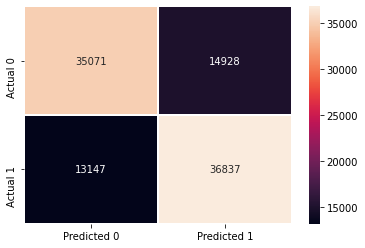

In [30]:
cnf_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model_01.predict(padded_comments_test), axis=1))

print(cnf_mat)
sns.heatmap(cnf_mat, annot=True, fmt='g', linewidths=.5, xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

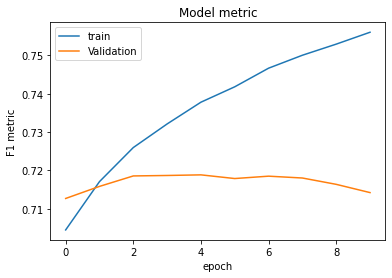

In [31]:
plt.plot(h1.history['f1_m'][1:])
plt.plot(h1.history['val_f1_m'][1:])
plt.title('Model metric')
plt.ylabel('F1 metric')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

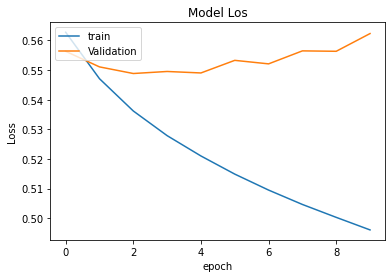

In [32]:
plt.plot(h1.history['loss'][1:])
plt.plot(h1.history['val_loss'][1:])
plt.title('Model Los')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

## Conclusions